In [1]:
import pandas as pd

from ast import literal_eval

from datetime import datetime    

import folium
import folium.plugins as plugins
from folium.plugins import BeautifyIcon

import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 8]

from keras.models import Sequential
from keras.layers import Dense

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

from tsextract.feature_extraction.extract import build_features 

TRAIN_RATIO = 0.8

TIMESTEPS = 24

WINDOW_SIZE = 24

FEATURES_REQUEST = {
    "window":[WINDOW_SIZE]
}

TILE = 'https://{s}.basemaps.cartocdn.com/light_nolabels/{z}/{x}/{y}{r}.png'
ATTR = '&copy; <a href="https://www.openstreetmap.org/copyright">OpenStreetMap</a> contributors &copy; <a href="https://carto.com/attributions">CARTO</a>',

In [2]:
def draw_linkpoints(m, linkpoints):
    for point in linkpoints:
        folium.CircleMarker(
            point,
            radius = 3,
            color = 'green',
            fill_color = 'green',
            fill_opacity = 0.8,
            fill = True).add_to(m)
        folium.PolyLine(
        locations=linkpoints,
        weight=3,
        color = 'red').add_to(m)

In [3]:
def swipe_coord(links):
    swiped_links = list()
    for i in range(0, len(links) - 1):
        swiped_links.append((links[i][1], links[i][0]))
    return swiped_links

In [4]:
def get_featured(df_init, features_request):
    
    X = build_features(df_init["Vehicles"], features_request, target_lag = 1, include_tzero=False)

    window_size = features_request['window'][0]

    y = df_init[['Vehicles']][window_size:-1]
    
    return [X, y]

In [5]:
def get_train_test_split(X, y, TRAIN_RATIO):
    X_train = X[:int(X.shape[0] * TRAIN_RATIO)]
    y_train = y[:int(y.shape[0] * TRAIN_RATIO)]

    X_test = X[int(X.shape[0] * TRAIN_RATIO):]
    y_test = y[int(y.shape[0] * TRAIN_RATIO):]
    
    return [X_train, y_train, X_test, y_test]

In [6]:
def get_train_test_split_scaled(X_train, y_train, X_test, y_test):
    X_scaler = MinMaxScaler()
    y_scaler = MinMaxScaler()

    X_train_scaled = X_scaler.fit_transform(X_train)
    y_train_scaled = pd.DataFrame(y_scaler.fit_transform(y_train), index = y_train.index)

    X_test_scaled = X_scaler.fit_transform(X_test)
    y_test_scaled = pd.DataFrame(y_scaler.fit_transform(y_test), index = y_test.index)
    
    return [X_train_scaled, y_train_scaled, X_test_scaled, y_test_scaled, y_scaler, X_scaler]

In [7]:
def get_predefined_FFNN_model(n_inputs):
    model = Sequential()
    model.add(Dense(100, input_dim = n_inputs, activation = 'relu'))
    model.add(Dense(50, activation = 'relu'))
    model.add(Dense(25, activation = 'relu'))
    model.add(Dense(1))
    model.compile(loss = 'mse', optimizer = 'adam', metrics = ['mse'])
    return model

In [8]:
def rolling_prediction_keras(model, df_init, timesteps, window_size):
    df = df_init.copy()
    df_windowed = df.copy()
    for i in range(0, timesteps):
        df_windowed = df[-2*window_size:]
        new = pd.DataFrame({"DateTime" : df_windowed.iloc[-1]['DateTime'] + pd.to_timedelta(1, unit = 'h'),
                            "Vehicles" : df['Vehicles'].iloc[-1]}, index = [df.shape[0]])
        df_windowed = df_windowed.append(new)
        features = build_features(df_windowed["Vehicles"], FEATURES_REQUEST, target_lag = 1, include_tzero=False)
        features_scaled = pd.DataFrame(X_scaler.fit_transform(features), index=features.index, columns=features.columns)
        predict_value = y_scaler.inverse_transform(model.predict(features_scaled.iloc[[-1]]))
        y_predict = pd.DataFrame({"DateTime" : df.iloc[-1]['DateTime'] + pd.to_timedelta(1, unit = 'h'),
                                  "Vehicles" : predict_value[0]}, index = [df.shape[0]])
        df = df.append(y_predict)
    return df

In [9]:
def get_scores(y_test, y_test_predict):
    r2 = r2_score(y_test, y_test_predict)
    rmse = mean_squared_error(y_test, y_test_predict, squared=False)
    mae = mean_absolute_error(y_test, y_test_predict)
    return [r2, rmse, mae]

In [10]:
def get_color(value, color_limits):
    min_value = color_limits[0]
    max_value = color_limits[2]
    step = color_limits[1]
    if (value >= min_value and value < min_value + step):
        return 'geen'
    elif (value >= min_value + step and value < min_value + 2*step):
        return 'green'
    elif (value >= min_value + 2*step and value < max_value - step):
        return 'orange'
    else:
        return 'red'

In [11]:
def draw_predicted_line(m, linkpoints, vehicle_value, color_limits):
    folium.PolyLine(
        locations=linkpoints,
        weight=3,
        color = get_color(vehicle_value, color_limits)).add_to(m_with_predictions)

In [12]:
VIEW_COORD = [40.753794347757804, -73.74431393817025]

LINKS = pd.read_csv('linkinfo.csv', error_bad_lines=False, converters={"linkPoints": literal_eval}).dropna()

m_init = folium.Map(location = VIEW_COORD, zoom_start = 16,
               tiles = TILE,
               attr = ATTR,
               zoom_control=False,
               scrollWheelZoom=False,
               dragging=False)

for linkid in LINKS['linkId'].values:
    linkpoints = LINKS[LINKS['linkId'] == linkid]['linkPoints'].values[0]
    draw_linkpoints(m_init, linkpoints)    
m_init

,linkid,r2-score,rmse,mae
0,4362247,0.885967,240.777514,193.568851
1,4362249,0.852803,109.964732,88.488979
2,4362251,0.856266,162.624033,124.231583
3,4362252,0.856960,243.051639,195.378191
4,4616351,0.879402,198.418945,154.019108


Text(0, 0.5, 'Vehicles')

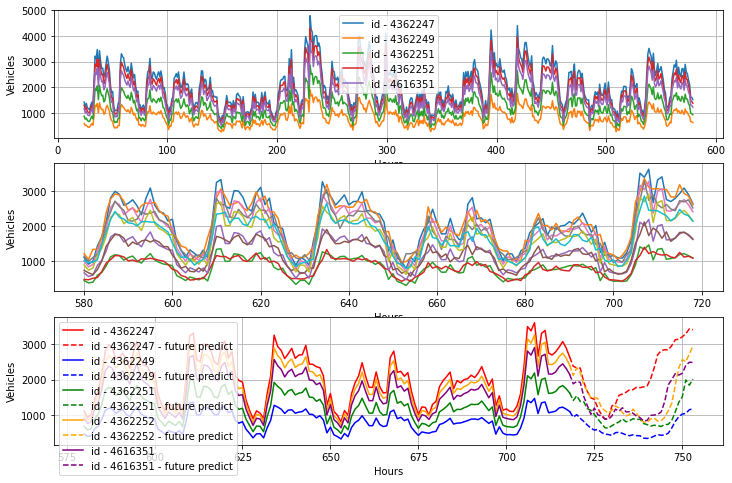

In [13]:
links = ['4362247', '4362249', '4362251', '4362252', '4616351']

errors = pd.DataFrame(columns = ['linkid', 'r2-score', 'rmse', 'mae'])

colors = {'4362247' : 'red',
         '4362249' : 'blue',
         '4362251' : 'green',
         '4362252' : 'orange',
         '4616351' : 'purple'}

colormap = dict()

future_predicts = list()

fig, (ax1, ax2, ax3) = plt.subplots(3, 1)


for link in links:
    df = pd.read_csv(link + '.csv')
    
    min_value = df.Vehicles.min()
    max_value = df.Vehicles.max()
    step = (max_value - min_value) / 4
    
    colormap[link] = [min_value, step, max_value]
    
    X, y = get_featured(df, FEATURES_REQUEST)
    X_train, \
    y_train, \
    X_test, \
    y_test = get_train_test_split(X, y, TRAIN_RATIO)
    X_train_scaled, \
    y_train_scaled, \
    X_test_scaled, \
    y_test_scaled, \
    y_scaler, \
    X_scaler = get_train_test_split_scaled(X_train, y_train, X_test, y_test)
    
    y_train.plot(ax = ax1, legend = None)
    
    model = get_predefined_FFNN_model(X_train.shape[1])
    model.fit(X_train_scaled, y_train_scaled, epochs = 100, batch_size = 200, verbose = 0)
    
    y_test_predict = pd.DataFrame(y_scaler.inverse_transform(model.predict(X_test_scaled)), index = y_test_scaled.index)
    
    y_test.plot(ax = ax2, legend = None)
    y_test_predict.plot(ax = ax2, legend = None)
    
    r2, rmse, mae = get_scores(y_test, y_test_predict)
    
    errors = errors.append({'linkid' : link,
                  'r2-score' : r2,
                  'rmse' : rmse,
                  'mae' : mae}, ignore_index = True)
    
    PREDICT_TIME = 34
    
    predict = rolling_prediction_keras(model, df, PREDICT_TIME , WINDOW_SIZE)[y_test.index.values[-1]:]
    future_predicts.append(predict)
    
    y_test.plot(ax = ax3, color = colors[link] )
    predict['Vehicles'].plot(ax = ax3, color = colors[link], style = '--')

display(errors.head(5))

ax1.legend(['id - 4362247', 'id - 4362249', 'id - 4362251', 'id - 4362252', 'id - 4616351'])
ax1.grid('on')
ax1.set_label('Train data')
ax1.set_xlabel('Hours')
ax1.set_ylabel('Vehicles')

ax2.grid('on')
ax2.set_label('Test data')
ax2.set_xlabel('Hours')
ax2.set_ylabel('Vehicles')

ax3.legend(['id - 4362247', 'id - 4362247 - future predict',
           'id - 4362249', 'id - 4362249 - future predict',
           'id - 4362251', 'id - 4362251 - future predict',
           'id - 4362252', 'id - 4362252 - future predict',
           'id - 4616351', 'id - 4616351 - future predict'])
ax3.grid('on')
ax3.set_label('Future predictions')
ax3.set_xlabel('Hours')
ax3.set_ylabel('Vehicles')

In [14]:
m_with_predictions = folium.Map(location = VIEW_COORD, zoom_start = 16,
               tiles = TILE,
               attr = ATTR,
               zoom_control=False,
               scrollWheelZoom=False,
               dragging=False)

for i in range(0, len(links)):
    color_limits = colormap[links[i]]
    vehicle_value = future_predicts[i].Vehicles.iloc[-1]
    linkpoints = LINKS[LINKS['linkId'] == int(links[i])]['linkPoints'].values[0]
    draw_predicted_line(m_with_predictions, linkpoints, vehicle_value, color_limits)
m_with_predictions

In [15]:
for i in range(0, len(links)):
    fp = future_predicts[i].drop(columns  = ['DateTime'])
    fp['Hours'] = fp.index
    fp.to_csv(links[i] + '_predict.csv', index = False, header=True)